# Import and Read Data

## Import module

In [1]:
import pandas as pd
import os
import numpy as np
from collections import defaultdict

import matplotlib.pyplot as plt
from matplotlib import colors, cm
from scipy.ndimage import gaussian_filter
import matplotlib.transforms as mtransforms
import matplotlib.colors as mcolors
import string
import matplotlib.patches as patches
import re

import matplotlib as mpl

##  Process CSV File for Cooperation Level

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Path to the folder containing the CSV files
folder_path = '/content/drive/MyDrive/inteaction_dynamics_in_social_dilemmas/data/'

# Get a list of all CSV files in the folder
csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]
print(csv_files)


# Dictionary to store the overall column means for each prefix
final_column_means_all_files = defaultdict(list)

# Dictionary to store suffixes for each prefix
file_suffixes = defaultdict(list)

# store eval cooperation level with time
run_cooperation_leval = {}


strategy_connection={}
strategy_connection_last={}
effective_connection={}

link_intensity_first={}
link_intensity_last={}
link_density={}



# store payoff for differnt dilemma strength
eval_payoff={}

# store gini coeffieicent for different dilemma strength
train_gini={}

# Window size for running average
window_size = 5


# Function to extract the last 5 non-NaN elements from a column
def last_5_non_nan(column):
    return column.dropna().tail(5)
def last_10_non_nan(column):
    return column.dropna().tail(10)

def first_15_nan(column):
    return column.dropna().head(15)

def first_25_nan(column):
    return column.dropna().head(25)

# Loop through each CSV file and calculate the mean for each column
for file_idx,csv_file in enumerate(csv_files):
    file_path = os.path.join(folder_path, csv_file)

    header_df = pd.read_csv(file_path,nrows=0)  # Adjust options based on your file structure

    # Select column names that contain 'eval'
    eval_column_indices = [i for i, col in enumerate(header_df.columns) if 'eval' in col]
    interact_column_indices = [i for i, col in enumerate(header_df.columns) if 'interact' in col]
    eval_timesetp_column_idx = eval_column_indices[0]
    run_column_indices = [i for i, col in enumerate(header_df.columns) if 'run' in col]


    eval_df = pd.read_csv(file_path, header=None, skiprows=1, usecols=eval_column_indices)
    interact_df=pd.read_csv(file_path, header=None, skiprows=1, usecols=interact_column_indices)
    run_df = pd.read_csv(file_path, header=None, skiprows=1, usecols=run_column_indices)

    # Filter the DataFrame to only include rows where have real timestep for eval
    eval_df = eval_df[eval_df.iloc[:, eval_timesetp_column_idx].notna()]


    # Apply the function to each column
    last_5_elements = eval_df.iloc[:, 1:].apply(last_5_non_nan) # Select all row, and select columns starting from the second column
    # print(last_5_elements)

    # Calculate the mean for each column
    final_column_means = last_5_elements.mean()

    # Extract prefix and suffix from filename
    file_prefix, file_suffix = csv_file.split('_')
    file_suffix = round(float(file_suffix.split('.')[0])/100, 2)  # Convert suffix to float
    memory_length=re.search(r'M\d+', file_prefix).group(0)

    if 'rl' in file_prefix:
      index_of_rl = file_prefix.find('rl')
      substring_before_rl = file_prefix[:index_of_rl] if index_of_rl > 0 else 'rl'

    # print(file_prefix, file_suffix)

    if file_suffix==1.2:
      eval_timestep=np.concatenate(eval_df.iloc[0:,0:1].to_numpy()).astype(int)

    # add interaction evolution ratio into array
    if not interact_df.empty:
      # print(f'{file_prefix}_{file_suffix}')


      interact_df = interact_df[interact_df.iloc[:, eval_timesetp_column_idx].notna()]
      coop_interact_column_idx = np.array([i for i, col in enumerate(header_df.columns) if 'interact_coop' in col])-interact_column_indices[0]
      defect_interact_column_idx = np.array([i for i, col in enumerate(header_df.columns) if 'interact_defect' in col])-interact_column_indices[0]

      effective_coop_column_idx = np.array([i for i, col in enumerate(header_df.columns) if 'interact_effective_c' in col])-interact_column_indices[0]
      effective_defect_column_idx = np.array([i for i, col in enumerate(header_df.columns) if 'interact_effective_d' in col])-interact_column_indices[0]


      cc_intensity_column_idx = np.array([i for i, col in enumerate(header_df.columns) if 'interact_cc_intensity' in col])-interact_column_indices[0]
      cd_intensity_column_idx = np.array([i for i, col in enumerate(header_df.columns) if 'interact_cd_intensity' in col])-interact_column_indices[0]
      dd_intensity_column_idx = np.array([i for i, col in enumerate(header_df.columns) if 'interact_dd_intensity' in col])-interact_column_indices[0]

      cc_link_column_idx = np.array([i for i, col in enumerate(header_df.columns) if 'cc_link' in col])-interact_column_indices[0]
      cd_link_column_idx = np.array([i for i, col in enumerate(header_df.columns) if 'cd_link' in col])-interact_column_indices[0]
      dd_link_column_idx = np.array([i for i, col in enumerate(header_df.columns) if 'dd_link' in col])-interact_column_indices[0]


      cooperation_interaction=interact_df.iloc[:, coop_interact_column_idx].T.to_numpy()
      defection_interaction=interact_df.iloc[:, defect_interact_column_idx].T.to_numpy()
      strategy_connection[substring_before_rl,memory_length,file_suffix]=[cooperation_interaction,defection_interaction]

      cooperation_interaction_last=interact_df.iloc[:, coop_interact_column_idx].apply(last_5_non_nan).T.to_numpy()
      defection_interaction_last=interact_df.iloc[:, defect_interact_column_idx].apply(last_5_non_nan).T.to_numpy()
      strategy_connection_last[substring_before_rl,memory_length,file_suffix]=[cooperation_interaction_last,defection_interaction_last]



      effective_coop_interaction=np.concatenate(interact_df.iloc[:, effective_coop_column_idx].apply(first_25_nan).T.to_numpy())
      effective_defect_interaction=np.concatenate(interact_df.iloc[:, effective_defect_column_idx].apply(first_25_nan).T.to_numpy())
      effective_connection[substring_before_rl,memory_length,file_suffix]=[effective_coop_interaction,effective_defect_interaction]

      cc_intensity_first=np.concatenate(interact_df.iloc[:, cc_intensity_column_idx].apply(first_15_nan).T.to_numpy())
      cd_intensity_first=np.concatenate(interact_df.iloc[:, cd_intensity_column_idx].apply(first_15_nan).T.to_numpy())
      dd_intensity_first=np.concatenate(interact_df.iloc[:, dd_intensity_column_idx].apply(first_15_nan).T.to_numpy())

      cc_intensity_last=np.concatenate(interact_df.iloc[:, cc_intensity_column_idx].apply(last_5_non_nan).T.to_numpy())
      cd_intensity_last=np.concatenate(interact_df.iloc[:, cd_intensity_column_idx].apply(last_5_non_nan).T.to_numpy())
      dd_intensity_last=np.concatenate(interact_df.iloc[:, dd_intensity_column_idx].apply(last_5_non_nan).T.to_numpy())


      cc_link=np.concatenate(interact_df.iloc[:, cc_link_column_idx].apply(last_5_non_nan).T.to_numpy())
      cd_link=np.concatenate(interact_df.iloc[:, cd_link_column_idx].apply(last_5_non_nan).T.to_numpy())
      dd_link=np.concatenate(interact_df.iloc[:, dd_link_column_idx].apply(last_5_non_nan).T.to_numpy())


      link_intensity_first[substring_before_rl,memory_length,file_suffix]=[cc_intensity_first,cd_intensity_first,dd_intensity_first]
      link_intensity_last[substring_before_rl,memory_length,file_suffix]=[cc_intensity_last,cd_intensity_last,dd_intensity_last]


      link_density[substring_before_rl,memory_length,file_suffix]=[cc_link,cd_link,dd_link]

    # deal with payoff info
    if any('payoff' in column.lower() for column in header_df.columns):
      payoff_column_indices = [i for i, col in enumerate(header_df.columns) if 'payoff' in col]
      # Get the inner idx for payoff_episode
      payoff_episode_idx = np.array([i for i, col in enumerate(header_df.columns) if 'payoff_episode' in col])-payoff_column_indices[0]
      payoff_coop_idx = np.array([i for i, col in enumerate(header_df.columns) if 'payoff_coop' in col])-payoff_column_indices[0]
      payoff_def_idx = np.array([i for i, col in enumerate(header_df.columns) if 'payoff_def' in col])-payoff_column_indices[0]

      payoff_df = pd.read_csv(file_path, header=None, skiprows=1,usecols=payoff_column_indices)
      payoff_df = payoff_df[payoff_df.iloc[:, 0].notna()]


      episode_payoff=np.concatenate(payoff_df.iloc[:, payoff_episode_idx].apply(last_5_non_nan).to_numpy())
      coop_payoff=np.concatenate(payoff_df.iloc[:, payoff_coop_idx].apply(last_5_non_nan).to_numpy())
      defect_payoff=np.concatenate(payoff_df.iloc[:, payoff_def_idx].apply(last_5_non_nan).to_numpy())
      eval_payoff[substring_before_rl,file_suffix]=[episode_payoff,coop_payoff,defect_payoff]

    # deal with train info
    if any ('train' in column.lower() for column in header_df.columns):
      # get gini coefficient
      train_column_indices = [i for i, col in enumerate(header_df.columns) if 'train' in col]
      gini_idx=np.array([i for i, col in enumerate(header_df.columns) if 'gini' in col])-train_column_indices[0]
      train_df = pd.read_csv(file_path, header=None, skiprows=1,usecols=train_column_indices)
      gini_df = train_df.iloc[:, gini_idx]
      gini_df=gini_df[gini_df.iloc[:,0].notna()]

      train_gini[substring_before_rl,file_suffix]=gini_df.T.to_numpy()
      train_timestep=np.concatenate(train_df.iloc[0:len(train_gini[substring_before_rl,file_suffix][0]),0:1].to_numpy()).astype(int)*2

    # extract rl time serise data
    if 'rl' in file_prefix and len(run_column_indices)>0 and  "M4" in  file_prefix:
      # coop_leveal = eval_df.iloc[:,1:]
      coop_leveal = run_df.iloc[:,1:]
      run_timestep=np.concatenate(run_df.iloc[:,0:1].to_numpy())*2
      # print(run_timestep)
      #  averaged_line = np.mean(averages, axis=0)
      # Transforming the DataFrame to a NumPy array
      # coop_leveal = coop_leveal.T.to_numpy()
      run_cooperation_leval[substring_before_rl,file_suffix]=coop_leveal.T.to_numpy()

    final_column_means_all_files[file_prefix].append(final_column_means.tolist())
    file_suffixes[file_prefix].append(file_suffix)

eval_payoff=dict(sorted(eval_payoff.items()))
run_cooperation_leval=dict(sorted(run_cooperation_leval.items()))
train_gini=dict(sorted(train_gini.items()))


# Display the results
print('eval result')
for prefix in final_column_means_all_files:
    sorted_suffixes_idx=np.argsort(file_suffixes[prefix])
    file_suffixes[prefix]=np.array(file_suffixes[prefix])[sorted_suffixes_idx].tolist()
    final_column_means_all_files[prefix]=np.array(final_column_means_all_files[prefix])[sorted_suffixes_idx].tolist()
    print(f"Prefix: {prefix}, Column Means: {final_column_means_all_files[prefix]}, Suffixes: {file_suffixes[prefix]}")

print('step result')
# print(run_cooperation_leval.keys())

# print(link_density)

# print(strategy_connection)
# for model,memory,dilemma in strategy_connection.keys():
#   print(model,memory,dilemma)
# print(effective_connection)

## Process NPZ file for strategy distribution

In [ ]:
import re

def extract_files(filenames):
  '''
  extract the dilemma strength from the filename
  '''
  # Regular expression pattern to match 'eval' followed by any number
  pattern = r'eval(\d+)_'
  extract_list=[]
  # Extracting the number for each filename
  for filename in filenames:
      match = re.search(pattern, filename)
      if match:
          number = float(match.group(1))/100
          extract_list.append(number)
          # print(f"Number in '{filename}': {number}")
  return extract_list

# Get a list of all NPZ files in the folder
npz_files = [file for file in os.listdir(folder_path) if file.endswith('.npz')]

distribution_dillemma_list=extract_files(npz_files)


# Process each npz file
for file_name in npz_files:
    file_path = os.path.join(folder_path, file_name)
    with np.load(file_path) as npz_file:
        print(f"Processing file: {file_name}")

        # Process each array in the npz file
        for array_name in npz_file.files:
            distribution_data = npz_file[array_name]

# print(len(distribution_data[-1][0]))


# Plot Data

## Global Setting

In [5]:
# Set Plot Colour
# four_dilemma_colors = ['#4a90e2', '#a084c3', '#5ba96d', '#f4a460']
four_dilemma_colors = ['#4a90e2', '#b29bc8', '#6cb97a', '#e0b088']
# four_dilemma_colors = ['#1f77b4', '#943dbd', '#2ca02c', '#ff7f0e']
interaction_ratio_color_set = np.array(["#0c056d", "#eaeaea", "#ff1414"])
strategy_color_set=np.array(["#0c056d", "#FF0000"])

# Set font size
single_figure_font_size=12
two_figure_font_size=12
multi_figure_font_size=13


plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

## Effect of interaction selection on cooperation

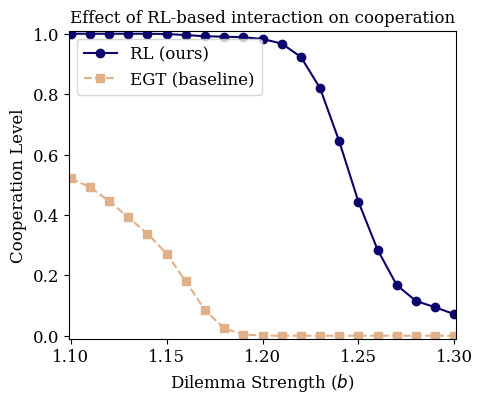

In [6]:

# Assuming final_column_means_all_files and suffixes are already computed

plt.figure(figsize=(5,4))

xaxis_label=[]

legend_list=['EGT (baseline)','RL (ours)']

# Find the maximum length of lists in the dictionary
max_length = max(len(lst) for lst in file_suffixes.values())

# Pad shorter lists with np.nan
padded_lists = [lst + [np.nan] * (max_length - len(lst)) for lst in file_suffixes.values()]

# Convert to a NumPy array
numpy_array = np.array(padded_lists)

for prefix in final_column_means_all_files.keys():
    if "M4" in  prefix and 'stra' not in prefix and 'one' not in prefix:
      # Get the means and corresponding suffixes for the current prefix
      means_list = final_column_means_all_files[prefix]
      suffix_list = file_suffixes[prefix]
      xaxis_label.append(suffix_list)

      # Flatten the list of means and calculate the overall mean for each file
      means = [np.mean(means) for means in means_list]

      sorted_pairs = sorted(zip(suffix_list, means))
      means = [item for _, item in sorted_pairs]
      suffix_list = [item for item, _ in sorted_pairs]

      # Calculate standard error (SE = standard deviation / sqrt(number of observations))
      standard_errors = [np.std(means) / np.sqrt(len(means)) for _ in means]

      if 'egt' in prefix:
        legend_label=legend_list[0]
        linestyle = '--'
        marker = 's'
        color =  '#e0b088'
      else:
         legend_label=legend_list[1]
         linestyle = '-'
         marker = 'o'
        #  color = '#3b75a8'
         color = strategy_color_set[0]
         RL_dillemma_mean=means
      # Plotting each line with error band
      plt.plot(suffix_list,gaussian_filter(means,sigma=1), color=color,label=legend_label, marker=marker,linestyle=linestyle)
      # plt.fill_between(suffix_list, np.array(means) - np.array(standard_errors), np.array(means) + np.array(standard_errors), alpha=0.2)




# Set y-axis limits and x-axis limits
plt.ylim(-0.01, 1.01)
plt.xlim(1.099, 1.301)


# Labeling the plot
plt.xlabel('Dilemma Strength ('+r'$b$'+')', fontsize=single_figure_font_size)
plt.ylabel('Cooperation Level',fontsize=single_figure_font_size)
plt.title('Effect of RL-based interaction on cooperation',fontsize=single_figure_font_size)
plt.legend(fontsize=single_figure_font_size,loc='best')

x_ticks = np.linspace(np.nanmin(numpy_array), np.nanmax(numpy_array), 5)
plt.xticks(np.around(x_ticks,decimals=2),fontsize=single_figure_font_size)
plt.yticks(fontsize=single_figure_font_size)

# Setting the x-axis to display with 2 decimal places
plt.gca().xaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))

# Display the plot
plt.show()
# plt.savefig('/content/drive/MyDrive/inteaction_dynamics_in_social_dilemmas/figures/fig2_overall_performance.eps', format='eps')

## Dynamics of Cooperation Evolution via RL

### The evolution of cooperation

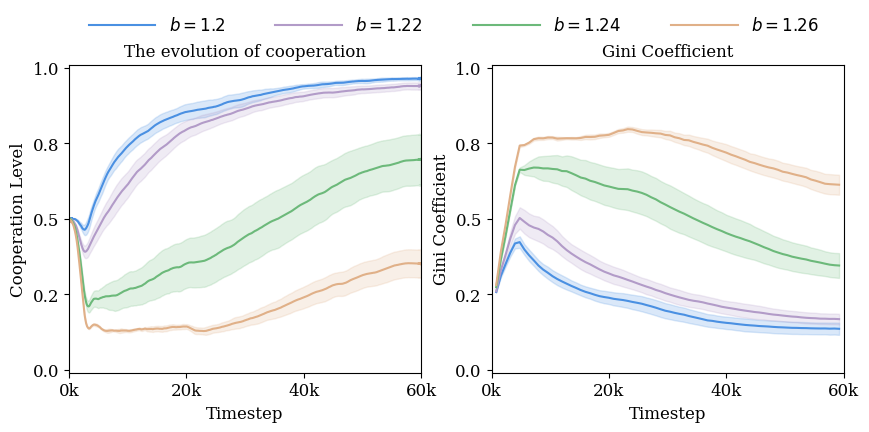

In [7]:
# Define a function to calculate the running average of a dataset
def running_average_ignore_nan(data, N):
    half_window = N // 2
    averaged_data = []

    for i in range(len(data)):
        # Determine the start and end of the window
        start = max(0, i - half_window)
        end = min(len(data), i + half_window + 1)

        # Create the window of data
        window = list(data[start:end])

        # If the window is incomplete, fill in with the central data
        while len(window) < N:
            if start == 0:
                window.append(data[i])
            else:
                window.insert(0, data[i])

        # Calculate the average and add to the result
        averaged_data.append(np.nanmean(window))
    return np.array(averaged_data)


# Define a function to calculate the standard error of the mean (SEM)
# def standard_error(data, window):
#     return np.nanstd(data, ddof=1, axis=0) / np.sqrt(window)


def standard_error_ignore_nan(datasets, window_size):
    '''
    Function to calculate standard error at each timestep, ignoring NaN values
    '''
    datasets_array = np.array(datasets)
    non_nan_count = np.count_nonzero(~np.isnan(datasets_array), axis=0)
    std_dev = np.nanstd(datasets_array, ddof=1, axis=0)
    return std_dev / np.sqrt(non_nan_count)

run_avg_list=[]
sem_run_avg=[]

# print(run_cooperation_leval.keys())
plot_dilemma_list=[ 1.2,1.22,  1.24,1.26]
dilemma_label=[f'$b={dilemma_strength}$' for dilemma_strength in plot_dilemma_list]
# plot_dilemma=run_cooperation_leval.keys()
# line_marker=['.','s','o','^']

plot_d=1.2

idx_plot_d_coop_level=np.where(np.array(plot_dilemma_list)==plot_d)[0][0]

window_size = 80  # Window size for the running average
for model_type,dilemma_strength in run_cooperation_leval.keys():
  if dilemma_strength in plot_dilemma_list and model_type=='rl':
    run_data_processed = []
    for run_data in run_cooperation_leval[model_type,dilemma_strength]:
      # Find the last non-NaN value in the array
      last_non_nan = run_data[~np.isnan(run_data)][-1]
      # Replace all NaN values with the last non-NaN value
      run_data[np.isnan(run_data)] = last_non_nan
      run_data_processed.append(running_average_ignore_nan(run_data, window_size))

    run_avg_list.append(run_data_processed)


mean_run_avg=[]
for run_avg in run_avg_list:
  mean_run_avg.append(np.nanmean(run_avg, axis=0))


# # Calculate the mean of the running averages
# mean_run_avg = np.nanmean(run_avg_list, axis=1)
# print(mean_run_avg)

# Calculate the standard error of the running averages
std_run_avg = [standard_error_ignore_nan(run_avg, window_size) for run_avg in run_avg_list]



gini_run_avg=[]

window_size = 5  # Window size for the running average
for model_type,dilemma_strength in train_gini.keys():
  if model_type=='rl':
    run_data_processed = []
    for run_data in train_gini[model_type,dilemma_strength]:
      # Find the last non-NaN value in the array
      last_non_nan = run_data[~np.isnan(run_data)][-1]
      # Replace all NaN values with the last non-NaN value
      run_data[np.isnan(run_data)] = last_non_nan
      run_data_processed.append(running_average_ignore_nan(run_data, window_size))

    gini_run_avg.append(run_data_processed)

gini_mean_run_avg=[]
for run_avg in gini_run_avg:
  gini_mean_run_avg.append(np.nanmean(run_avg, axis=0))

# Calculate the standard error of the running averages
gini_std_run_avg = [standard_error_ignore_nan(run_avg, window_size) for run_avg in gini_run_avg]
# print(gini_std_run_avg)

# plt.figure(figsize=(6,4))

Nr=1
Nc=2
fig, axs = plt.subplots(Nr, Nc, figsize=(10,4 ))
plt.subplots_adjust(wspace=0.2, hspace=0.4)

total_time=round(run_timestep[-1] / 5000) * 5000

fig_idx=0
for Nr_idx in range(Nr):
  for Nc_idx in range(Nc):
    if fig_idx==0:
      # Plotting
      for idx,dilemma_strength in enumerate(plot_dilemma_list):
        color = four_dilemma_colors[idx]
        # maker=line_marker[idx]
        axs[fig_idx].plot(run_timestep, mean_run_avg[idx], label=dilemma_label[idx],color=color)
      for idx,dilemma_strength in enumerate(plot_dilemma_list):
        color = four_dilemma_colors[idx]
        axs[fig_idx].fill_between(run_timestep, mean_run_avg[idx] - std_run_avg[idx], mean_run_avg[idx] + std_run_avg[idx], alpha=0.2,color=color)

      axs[fig_idx].set_title('The evolution of cooperation',fontsize=two_figure_font_size)
      axs[fig_idx].set_ylabel('Cooperation Level',fontsize=two_figure_font_size)
    elif fig_idx==1:
      # Plotting
      idx=0
      for model_type,dilemma_strength in train_gini.keys():
        if model_type=='rl':
          color = four_dilemma_colors[idx]
          axs[fig_idx].plot(train_timestep, gini_mean_run_avg[idx], label=f'b={dilemma_strength}',color=color)
          axs[fig_idx].fill_between(train_timestep, gini_mean_run_avg[idx] - gini_std_run_avg[idx], gini_mean_run_avg[idx] + gini_std_run_avg[idx],color=color, alpha=0.2)
          idx+=1
      axs[fig_idx].set_ylabel('Gini Coefficient',fontsize=two_figure_font_size)
      axs[fig_idx].set_title('Gini Coefficient',fontsize=two_figure_font_size)
      axs[fig_idx].set_xlabel('Timestep',fontsize=two_figure_font_size)

    # Adding labels and title
    axs[fig_idx].set_xlabel('Timestep',fontsize=two_figure_font_size)

    # plt.legend(ncols=len(plot_dilemma),bbox_to_anchor=(1.2, 1.2),fontsize=two_figure_font_size-1)

    axs[fig_idx].set_ylim(-0.01, 1.01)
    axs[fig_idx].set_xlim(0,total_time)
    # Define x-axis labels
    x_labels = [f"{i//1000}k" for i in range(0, total_time + 1, 20000)]
    axs[fig_idx].set_xticks(np.arange(0, total_time + 1, 20000), labels=x_labels,fontsize=two_figure_font_size)  # Set custom x-axis labels
    axs[fig_idx].set_yticks(np.linspace(0, 1, 5))
    axs[fig_idx].set_yticklabels(np.around(np.linspace(0, 1, 5), decimals=1),fontsize=two_figure_font_size)
    fig_idx+=1

fig.legend(labels=dilemma_label,ncol=len(plot_dilemma_list),fontsize=two_figure_font_size,bbox_to_anchor=(0.51, 0.98, 0, 0),frameon=False,loc="center",columnspacing=3,handlelength=4,handleheight=0.1,)

# Display the plot
plt.show()
# plt.savefig('/content/drive/MyDrive/inteaction_dynamics_in_social_dilemmas/figures/fig3_time_evolution.eps', format='eps')

### Episode Payoff

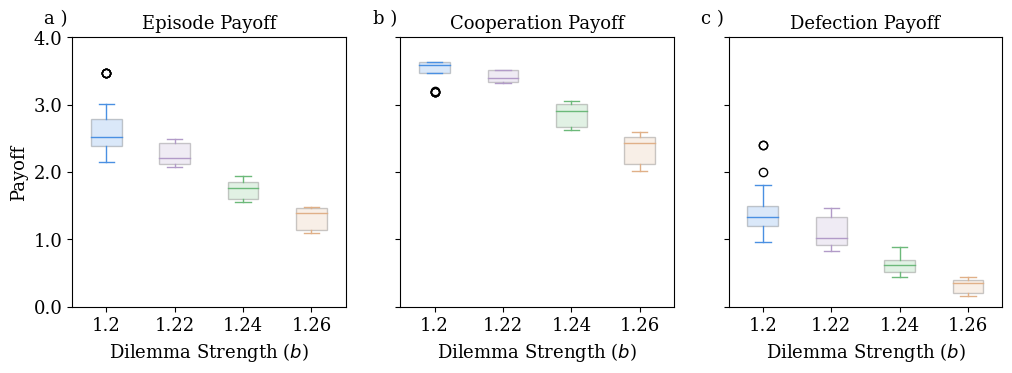

In [8]:
Nr=1
Nc=3
fig, axs = plt.subplots(Nr, Nc, figsize=(12, 3.5))
plt.subplots_adjust(wspace=0.2, hspace=0.3)


# print(eval_payoff)
plot_payoff_data=[[],[],[]]
plot_title=['Episode Payoff','Cooperation Payoff','Defection Payoff']

for idx in range(len(plot_payoff_data)):
  for model_type,dilemma_strength in eval_payoff.keys():
    if model_type=='rl':
      plot_payoff_data[idx].append(eval_payoff[model_type,dilemma_strength][idx])

# index all subgraph
trans = mtransforms.ScaledTranslation(-20 / 72, 7 / 72, fig.dpi_scale_trans)



alphabet = string.ascii_lowercase
fig_idx=0
for Nr_idx in range(Nr):
  for Nc_idx in range(Nc):
      parts=axs[fig_idx].boxplot(plot_payoff_data[fig_idx],vert=True,  # vertical box alignment
                     patch_artist=True)
      for idx,pc in enumerate(parts['boxes']):
        pc.set_facecolor(four_dilemma_colors[idx])
        pc.set_alpha(0.2)
      for idx,pc in enumerate(parts['medians']):
        pc.set_color(four_dilemma_colors[idx])
      for idx,pc in enumerate(parts['caps']):
          value=idx//2
          pc.set_color(four_dilemma_colors[value])
      for idx,pc in enumerate(parts['whiskers']):
          value=idx//2
          pc.set_color(four_dilemma_colors[value])
      for idx,pc in enumerate(parts['fliers']):
          pc.set_color(four_dilemma_colors[idx])

      # if 'cmeans' in parts:
      #   parts['cmins'].set_color(plot_colors)  # Set color for the medians
      #   parts['cbars'].set_color(plot_colors)  # Set color for the medians
      #   parts['cmaxes'].set_color(plot_colors)  # Set color for the medians
      #   parts['cmeans'].set_color(plot_colors)  # Set color for the medians


      axs[fig_idx].set_ylim(0,4)
      axs[fig_idx].set_yticks(np.linspace(0, 4, 5))
      axs[fig_idx].set_yticklabels(np.linspace(0, 4, 5),fontsize=multi_figure_font_size)
      axs[fig_idx].set_title(plot_title[fig_idx],fontsize=multi_figure_font_size)
      # ax.yaxis.grid(True)
      axs[fig_idx].set_xticks([y + 1 for y in range(len(plot_dilemma_list))],
                    labels=plot_dilemma_list,fontsize=multi_figure_font_size)
      axs[fig_idx].set_xlabel('Dilemma Strength ('+r'$b$'+')',fontsize=multi_figure_font_size)
      axs[fig_idx].set_ylabel('Payoff',fontsize=multi_figure_font_size)

      axs[fig_idx].text(
                    0.0,
                    1.0,
                    alphabet[fig_idx] + " )",
                    transform=axs[fig_idx].transAxes + trans,
                    fontsize=multi_figure_font_size,
                    va="bottom",
                    fontfamily="serif",
                )
      axs[fig_idx].label_outer()
    # axs[Nr_idx,Nc_idx].label_outer()
      fig_idx+=1
    # plt.boxplot(eval_payoff[dilemma_strength])



# # axs[0].set_title('Violin plot')

# # plot box plot
# axs[1].boxplot(all_data)
# axs[1].set_title('Box plot')

# plt.savefig('/content/drive/MyDrive/inteaction_dynamics_in_social_dilemmas/figures/fig3_payoff.eps', format='eps')
plt.show()

## The relationship between Cooperaiton and Interaction

### Interaction Ratio

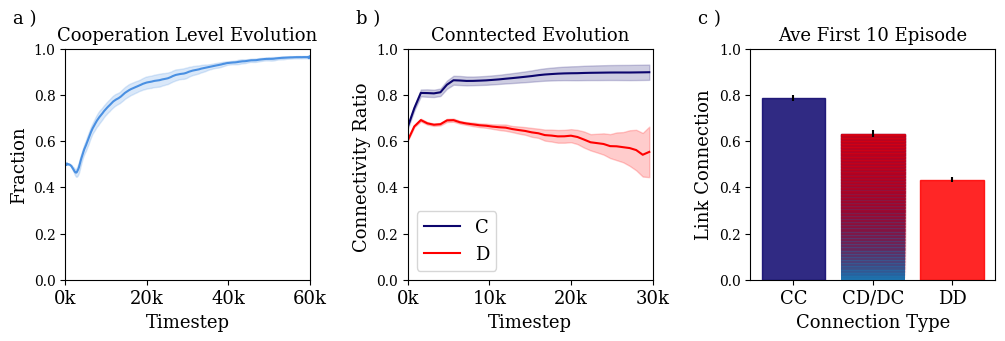

In [9]:
Nr=1
Nc=3

fig, axs = plt.subplots(Nr, Nc, figsize=(12, 3))
plt.subplots_adjust(wspace=0.4, hspace=0.2)

# Adding transparency: Let's assume an alpha value of 0.5 for medium transparency
alpha_value = 0.85
transparent_color_set = [mcolors.to_rgba(color, alpha=alpha_value) for color in strategy_color_set]
# Initialize the figure_index to start with 'a'
alphabet = string.ascii_lowercase
plot_dilemma=1.2
plot_memory='M4'
model_type='rl'


idx=0
for n_r in range(Nr):
  for n_c in range(Nc):
    if idx==0:
      color = four_dilemma_colors[idx_plot_d_coop_level]
      axs[idx].plot(run_timestep, mean_run_avg[idx_plot_d_coop_level], label=f'b={dilemma_strength}',color=color)
      axs[idx].fill_between(run_timestep, mean_run_avg[idx_plot_d_coop_level] - std_run_avg[idx_plot_d_coop_level], mean_run_avg[idx_plot_d_coop_level] + std_run_avg[idx_plot_d_coop_level], alpha=0.2,color=color)
      axs[idx].set_xlim(0,total_time)
      # Define x-axis labels
      x_labels = [f"{i//1000}k" for i in range(0, total_time + 1, 20000)]
      axs[idx].set_xticks(np.arange(0, total_time + 1, 20000), labels=x_labels,fontsize=multi_figure_font_size)  # Set custom x-axis labels
      axs[idx].set_xlabel('Timestep',fontsize=multi_figure_font_size)
      axs[idx].set_ylabel('Fraction',fontsize=multi_figure_font_size)
      axs[idx].set_title('Cooperation Level Evolution',fontsize=multi_figure_font_size)

    elif idx==1:
      label=['C','D']
      for s_idx in range(2):
        color=strategy_color_set[s_idx]

        # Find the last non-NaN value in the array
        run_interact = strategy_connection[model_type,plot_memory,plot_dilemma][s_idx]

        # print(run_interact)
        # print(eval_timestep)

        run_interact = np.insert(run_interact, 0, 0.5, axis=1)
        new_eval_timestep=np.insert(eval_timestep, 0, 0.5)


        window_size=10
        run_interact_processed = []
        for data in run_interact:
          run_interact_processed.append(running_average_ignore_nan(data, window_size))
        plot_interact=np.nanmean(run_interact_processed, axis=0)
        interac_std_run_avg = standard_error_ignore_nan(run_interact_processed, window_size)

        axs[idx].plot(new_eval_timestep,plot_interact,color=color,label=label[s_idx])
        axs[idx].fill_between( new_eval_timestep,plot_interact - interac_std_run_avg, plot_interact + interac_std_run_avg,color=color, alpha=0.2)

      # Define x-axis labels
      axs[idx].set_xlim(0,total_time/2)
      x_labels = [f"{i//1000}k" for i in range(0, int(total_time/2) + 1, 10000)]
      axs[idx].set_xticks(np.arange(0, int(total_time /2) + 1, 10000), labels=x_labels,fontsize=multi_figure_font_size)  # Set custom x-axis labels
      axs[idx].set_xlabel('Timestep',fontsize=multi_figure_font_size)
      axs[idx].set_ylabel('Connectivity Ratio ',fontsize=multi_figure_font_size)
      axs[idx].set_title('Conntected Evolution',fontsize=multi_figure_font_size)
      axs[idx].legend(fontsize=multi_figure_font_size)

    elif idx==2:
      intensity_first=np.nanmean(link_intensity_first[model_type,plot_memory,plot_dilemma],axis=1)
      # intensity_last=np.nanmean(link_intensity_last[plot_dilemma],axis=1)
      # print(intensity_first,intensity_last)

      std_error = [standard_error_ignore_nan(data, 1) for data in link_intensity_first[model_type,plot_memory,plot_dilemma]]
      x_labels=['CC','CD/DC','DD']
      # print(intensity_first)
      bars=axs[idx].bar(x_labels,intensity_first,yerr=std_error)

      bars[0].set_color(transparent_color_set[0])  # First bar
      bars[2].set_color(transparent_color_set[1])   # Last bar
      # Create a gradient effect for the middle bar
      gradient_bar = bars[1]
      bottom, top = gradient_bar.get_y(), gradient_bar.get_y() + gradient_bar.get_height()
      CD_DC_color = [(1, 0, 0, alpha) for alpha in np.linspace(0, 0.7, 100)] # Red to transparent
      CC_color = [(0.047058823529411764, 0.0196078431372549, 0.42745098039215684, alpha) for alpha in np.linspace(0, 0.7, 100)] # Blue to transparent
      axs[idx].set_ylabel('Link Connection',fontsize=multi_figure_font_size)
      axs[idx].set_xlabel('Connection Type',fontsize=multi_figure_font_size)
      axs[idx].xaxis.set_ticks([0,1,2])
      axs[idx].xaxis.set_ticklabels(x_labels, fontsize=multi_figure_font_size)
      # Add a rectangle with gradient color
      for i, color in enumerate(zip(CC_color, CD_DC_color)):
          rect = patches.Rectangle((gradient_bar.get_x(), bottom + i * (top-bottom)/100),
                                  gradient_bar.get_width(), (top-bottom)/100, color=color[0])
          axs[idx].add_patch(rect)
          rect = patches.Rectangle((gradient_bar.get_x(), bottom + i * (top-bottom)/100),
                                  gradient_bar.get_width(), (top-bottom)/100, color=color[1])
          axs[idx].add_patch(rect)
      axs[idx].set_title('Ave First 10 Episode',fontsize=multi_figure_font_size)
    if idx==3:
      link_last=np.nanmean(link_density[plot_dilemma],axis=1)
      # print(link_last)
      axs[idx].pie(link_last, radius=3, center=(4, 4),
       wedgeprops={"linewidth": 1, "edgecolor": "white"}, frame=True)
    else:
      axs[idx].set_ylim(0.0,1.00)
    axs[idx].text(
                    -0.1,
                    1.05,
                    alphabet[idx] + " )",
                    transform=axs[idx].transAxes + trans,
                    fontsize=multi_figure_font_size,
                    va="bottom",
                    fontfamily="serif",
                )
    idx+=1

# plt.savefig('/content/drive/MyDrive/inteaction_dynamics_in_social_dilemmas/figures/fig4_interaction.eps', format='eps')
plt.show()

### Strategy Distribution

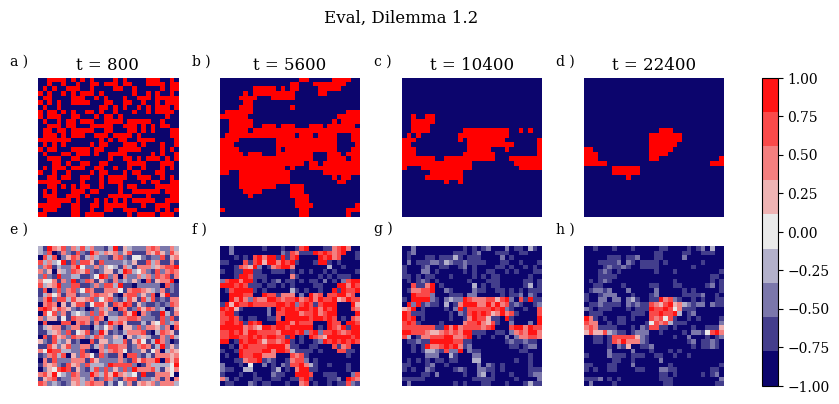

In [10]:

# print(len(distribution_data))
# give the selected timestep
selected_timesteps=[0,6,12,27]


cmap = colors.ListedColormap(strategy_color_set)
cmap_interact = colors.LinearSegmentedColormap.from_list("my_list", interaction_ratio_color_set, N=9)
images=[]


Nc=len(selected_timesteps)
fig, axs = plt.subplots(2, Nc, figsize=(10, 4))

# index all subgraph
trans = mtransforms.ScaledTranslation(
                -20 / 72, 7 / 72, fig.dpi_scale_trans)

# Initialize the figure_index to start with 'a'
figure_index = 0
alphabet = string.ascii_lowercase

for Nr_idx in range(2):
  for Nc_idx in range(Nc):
    if Nr_idx==0:
      images.append(axs[Nr_idx,Nc_idx].imshow(distribution_data[selected_timesteps[Nc_idx]][0], cmap=cmap))
      axs[Nr_idx,Nc_idx].set_title('t = %s'%((selected_timesteps[Nc_idx]+1)*800 if selected_timesteps[Nc_idx]!=-1 else (len(distribution_data)+1)*800))
    else:
      images.append(axs[Nr_idx,Nc_idx].imshow(distribution_data[selected_timesteps[Nc_idx]][0], cmap=cmap_interact, vmin=-1, vmax=1))
      # fig.colorbar(im, ax=ax)
    axs[Nr_idx,Nc_idx].axis("off")

    axs[Nr_idx,Nc_idx].text(
                    0.0,
                    1.0,
                    alphabet[figure_index] + " )",
                    transform=axs[Nr_idx,Nc_idx].transAxes + trans,
                    fontsize=10,
                    va="bottom",
                    fontfamily="serif",
                )

    figure_index+=1

norm = colors.Normalize(vmin=-1, vmax=1)
# print(graph_list_with_heterogeneity)
for im in images:
    im.set_norm(norm)

fig.colorbar(images[-1], ax=axs,fraction=0.05,location='right',shrink=1, aspect=20)

# # Create an axes for color bar
# cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7]) # [left, bottom, width, height] in figure coordinate
# fig.colorbar(images[-1], cax=cbar_ax)

# # Adjust the rest of the figure layout
# fig.subplots_adjust(right=0.9)  # Make room for color bar



fig.suptitle(
    "Eval, Dilemma {}".format(
      distribution_dillemma_list[0]
    ),y=1.05
)
# fig.tight_layout()

# plt.savefig('/content/drive/MyDrive/inteaction_dynamics_in_social_dilemmas/figures/fig5_distribution.eps', format='eps')
plt.show()

## Role of Past Experience

### Effective Cooperation

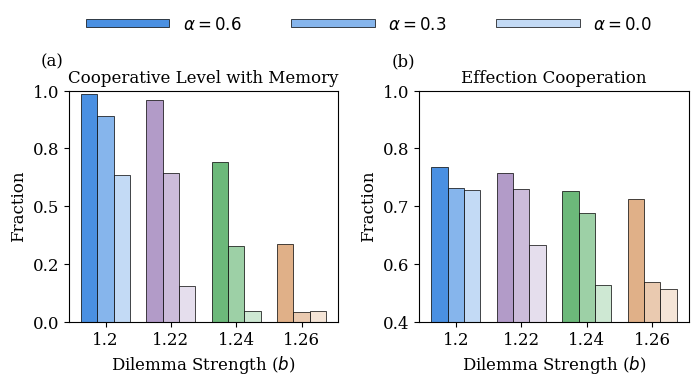

In [21]:
from matplotlib.colors import to_hex, to_rgb

plot_dilemma=[ 1.2,1.22,  1.24,1.26]
plot_memory=['M1','M2','M4']
memory_alpha=[0.0,0.3,0.6]
plot_label=[f'$\\alpha={memory_alpha[::-1][m_idx]}$' for m_idx in range(len(plot_memory))]

def lighten_color(color):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.
    """
    color_list=[color]
    for amount in [0.666,0.333]:
        c = to_rgb(color)
        c = [1 - (1 - x) * amount for x in c]
        color_list.append(c)
    return color_list


# Generate sub-colors for each main color
sub_colors = [lighten_color(color) for color in four_dilemma_colors]
# print(np.transpose(sub_colors))

# {'#4a90e2': ['#4a90e2', '#3b73b5', '#2c5688'], '#b29bc8': ['#b29bc8', '#8e7ca0', '#6b5d78'], '#6cb97a': ['#6cb97a', '#569462', '#416f49'], '#e0b088': ['#e0b088', '#b38d6d', '#866a52']}

# Define the main colors
# main_colors = [['#4a90e2','#a00000','#1f6f6f','#5e4c5f'], ['#3b73b5','#c46666','#54a1a1','#999999'],  ['#2c5688','#d8a6a6','#91c8c8',"#b8b8b8"]]  # Light Blue, Soft Green, Pale Yellow
main_colors =np.transpose(sub_colors)




cooperation_memory_length={}
effection_cooperation_memory_length={}
effection_defection_memory_length={}

# Regular expression to extract the pattern 'M' followed by any number
pattern = r'M\d+'

plot_d=1.2

idx_plot_d_coop_level=np.where(np.array(plot_dilemma)==plot_d)[0][0]

window_size = 80  # Window size for the running average
for prefix in final_column_means_all_files.keys():
  if 'rl' in prefix and 'stra' not in prefix and 'one' not in prefix:
    memory_length = re.search(pattern, prefix).group()
    cooperation_memory_length[memory_length]=[]
    dilemma_order=[]

    for idx,suffix in enumerate(file_suffixes[prefix]):
        if suffix in plot_dilemma:
          cooperation_memory_length[memory_length].append(np.mean(final_column_means_all_files[prefix][idx]))
          dilemma_order.append(suffix)
    # Sorting dilemma_order and rearranging cooperation_memory_length accordingly
    sorted_indices = np.argsort(dilemma_order)
    # print(f'memory length: {memory_length}, dillema order: {np.array(dilemma_order)[sorted_indices]}')
    cooperation_memory_length[memory_length] = np.array(cooperation_memory_length[memory_length])[sorted_indices]

# print(cooperation_memory_length)

Nr=1
Nc=2

fig, axs = plt.subplots(Nr, Nc, figsize=(8, 3))
plt.subplots_adjust(wspace=0.3, hspace=0.2)




effective_cooperation=[]
effective_defection=[]
for p_d in plot_dilemma:
  pd_cooperation=np.zeros(len(plot_memory))
  pd_defection=np.zeros(len(plot_memory))
  for model,memory,dilemma in effective_connection.keys():
    if p_d==dilemma and model=='rl':
      memory_index=plot_memory.index(memory)
      pd_cooperation[memory_index]=np.mean(effective_connection[model,memory,p_d],axis=1)[0]
      pd_defection[memory_index]=np.mean(effective_connection[model,memory,p_d],axis=1)[1]


  effective_cooperation.append(pd_cooperation)
  effective_defection.append(pd_defection)

# print('Effective Cooperation')
effective_cooperation=np.transpose(effective_cooperation)
# print('Effective Defection')
effective_defection=np.transpose(effective_defection)


for idx,memeory_length in enumerate(plot_memory):
  effection_cooperation_memory_length[memeory_length]=effective_cooperation[idx]
  effection_defection_memory_length[memeory_length]=np.negative(effective_defection[idx])

# print(effection_cooperation_memory_length)
# print(effection_defection_memory_length)


# print('=====\n')

# print('Memory Cooperation Level')
idx=0
for n_r in range(Nr):
  for n_c in range(Nc):
    if idx==0:
      bar_width = 0.25
      multiplier = 0
      x = np.arange(len(plot_dilemma))  # the label locations

      for m_idx,memory_length in enumerate(plot_memory[::-1]):
        offset=bar_width*m_idx
        main_color = main_colors[m_idx % len(main_colors)]
        axs[idx].bar(x+offset, cooperation_memory_length[memory_length], bar_width, label= plot_label[m_idx],color=main_color,edgecolor='black',linewidth=0.5)

      y_1=0.0
      y_2=1.0
      axs[idx].set_ylim(y_1, y_2)
      axs[idx].set_yticks(np.linspace(y_1, y_2, 5))
      axs[idx].set_yticklabels(np.around(np.linspace(y_1, y_2, 5), decimals=1),fontsize=two_figure_font_size)
      axs[idx].set_title('Cooperative Level with Memory',fontsize=two_figure_font_size)
      # axs[idx].legend(loc='upper right', ncols=1,fontsize=two_figure_font_size-2)

    else:
      bar_width = 0.25
      multiplier = 0
      for m_idx,memory_length in enumerate(plot_memory[::-1]):
        offset=bar_width*m_idx
        main_color = main_colors[m_idx % len(main_colors)]
        axs[idx].bar(x+offset, effection_cooperation_memory_length[memory_length], bar_width, label= f'$\\alpha={memory_alpha[::-1][m_idx]}$',color=main_color,edgecolor='black',linewidth=0.5)
        # axs[idx].bar(x+offset, effection_defection_memory_length[memory_length], bar_width, label= f'$\\alpha={memory_alpha[::-1][m_idx]}$',color=main_color,edgecolor='black')

      y_1=0.4
      y_2=1
      axs[idx].set_ylim(y_1, y_2)
      axs[idx].set_title('Effection Cooperation',fontsize=two_figure_font_size)

      axs[idx].set_yticks(np.linspace(y_1, y_2, 5))
      axs[idx].set_yticklabels(np.around(np.linspace(y_1, y_2, 5), decimals=1),fontsize=two_figure_font_size)
      # axs[idx].legend(loc='upper right', ncols=1,fontsize=two_figure_font_size-2)

    axs[idx].set_xlabel('Dilemma Strength ('+r'$b$'+')',fontsize=two_figure_font_size)
    axs[idx].set_ylabel('Fraction',fontsize=two_figure_font_size)
    axs[idx].set_xticks(x + bar_width, plot_dilemma,fontsize=two_figure_font_size)


    # axs[idx].label_outer()

    axs[idx].text(
                    0.0,
                    1.05,
                    "("+alphabet[idx] + ")",
                    transform=axs[idx].transAxes + trans,
                    fontsize=two_figure_font_size,
                    va="bottom",
                    fontfamily="serif",
                )


    idx+=1

fig.legend(labels=plot_label,ncol=len(plot_label),fontsize=two_figure_font_size,bbox_to_anchor=(0.5, 1.1, 0, 0),frameon=False,loc="center",columnspacing=3,handlelength=5,handleheight=0.4,)

# plt.savefig('/content/drive/MyDrive/inteaction_dynamics_in_social_dilemmas/figures/fig6_experience.eps', format='eps')
plt.show()

# Additional Result

## preprocessing

### Interaction Data

In [12]:
# print(effection_cooperation_memory_length)
# print(positive_effection_defection_memory_length)
positive_effection_defection_memory_length = {key: np.abs(value) for key, value in effection_defection_memory_length.items()}
decimal_round=2

positive_effection_defection_memory_length={key: np.round(value, 2) for key, value in positive_effection_defection_memory_length.items()}
effection_cooperation_memory_length={key: np.round(value, 2) for key, value in effection_cooperation_memory_length.items()}

cc_intensity=[]
cd_intensity=[]
dd_intensity=[]
cc_density=[]
cd_density=[]
dd_density=[]
c_connection=[]
d_connection=[]
# iterate all plot dilemma
for p_d in plot_dilemma:
  # link intensity
  pd_cc_intensity=np.zeros(len(plot_memory))
  pd_cd_intensity=np.zeros(len(plot_memory))
  pd_dd_intensity=np.zeros(len(plot_memory))
  # link density
  pd_cc_density=np.zeros(len(plot_memory))
  pd_cd_density=np.zeros(len(plot_memory))
  pd_dd_density=np.zeros(len(plot_memory))

  pd_c_connection=np.zeros(len(plot_memory))
  pd_d_connection=np.zeros(len(plot_memory))

  # iterate all memory for specific dilemma strength
  for model,memory,dilemma in link_intensity_first.keys():
    if p_d==dilemma and model=='rl':
      memory_index=plot_memory.index(memory)
      pd_cc_intensity[memory_index]=round(np.mean(link_intensity_first[model,memory,p_d],axis=1)[0],decimal_round)
      pd_cd_intensity[memory_index]=round(np.mean(link_intensity_first[model,memory,p_d],axis=1)[1],decimal_round)
      pd_dd_intensity[memory_index]=round(np.mean(link_intensity_first[model,memory,p_d],axis=1)[2],decimal_round)
  cc_intensity.append(pd_cc_intensity)
  cd_intensity.append(pd_cd_intensity)
  dd_intensity.append(pd_dd_intensity)

  # iterate all memory for specific dilemma strength
  for model,memory,dilemma in link_density.keys():
    if p_d==dilemma and model=='rl':
      memory_index=plot_memory.index(memory)
      pd_cc_density[memory_index]=round(np.mean(link_density[model,memory,p_d],axis=1)[0],decimal_round)
      pd_cd_density[memory_index]=round(np.mean(link_density[model,memory,p_d],axis=1)[1],decimal_round)
      pd_dd_density[memory_index]=round(np.mean(link_density[model,memory,p_d],axis=1)[2],decimal_round)
  cc_density.append(pd_cc_density)
  cd_density.append(pd_cd_density)
  dd_density.append(pd_dd_density)


  # iterate all memory for specific dilemma strength
  for model,memory,dilemma in strategy_connection_last.keys():
    if p_d==dilemma and model=='rl':
      memory_index=plot_memory.index(memory)
      pd_c_connection[memory_index]=round(np.mean(np.mean(strategy_connection_last[model,memory,p_d],axis=1),axis=1)[0],decimal_round)
      pd_d_connection[memory_index]=round(np.mean(np.mean(strategy_connection_last[model,memory,p_d],axis=1),axis=1)[1],decimal_round)
  c_connection.append(pd_c_connection)
  d_connection.append(pd_d_connection)


# transpose dilemma-memeory to memory-dilemma
cc_intensity=np.transpose(cc_intensity)
cd_intensity=np.transpose(cd_intensity)
dd_intensity=np.transpose(dd_intensity)

cc_density=np.transpose(cc_density)
cd_density=np.transpose(cd_density)
dd_density=np.transpose(dd_density)

c_connection=np.transpose(c_connection)
d_connection=np.transpose(d_connection)



cc_intensity_memory_length={}
cd_intensity_memory_length={}
dd_intensity_memory_length={}
for idx,memeory_length in enumerate(plot_memory):
  cc_intensity_memory_length[memeory_length]=cc_intensity[idx]
  cd_intensity_memory_length[memeory_length]=cd_intensity[idx]
  dd_intensity_memory_length[memeory_length]=dd_intensity[idx]


cc_density_memory_length={}
cd_density_memory_length={}
dd_density_memory_length={}
for idx,memeory_length in enumerate(plot_memory):
  cc_density_memory_length[memeory_length]=cc_density[idx]
  cd_density_memory_length[memeory_length]=cd_density[idx]
  dd_density_memory_length[memeory_length]=dd_density[idx]


c_connection_memory_length={}
d_connection_memory_length={}
for idx,memeory_length in enumerate(plot_memory):
  c_connection_memory_length[memeory_length]=c_connection[idx]
  d_connection_memory_length[memeory_length]=d_connection[idx]

interaction_column_data=[effection_cooperation_memory_length,positive_effection_defection_memory_length,cc_density_memory_length,cd_density_memory_length,dd_density_memory_length,cc_intensity_memory_length,cd_intensity_memory_length,dd_intensity_memory_length,c_connection_memory_length,d_connection_memory_length]

### Singe & Strategy Data

In [13]:
plot_memory_one=['M4']
plot_dilemma_one=[1.2]

effection_cooperation_memory_length_dual_one={}
effection_defection_memory_length_dual_one={}

episode_payoff_memory_length_one={}
coop_payoff_memory_length_one={}

coop_level_memory_length_one={}
gini_memory_length_one={}

effective_cooperation_one=[]
effective_defection_one=[]

episode_payoff_one=[]
coop_payoff_one=[]


coop_level=[]
gini_value=[]

for p_d in plot_dilemma_one:
  pd_cooperation=np.zeros(len(plot_memory_one))
  pd_defection=np.zeros(len(plot_memory_one))
  for model,memory,dilemma in effective_connection.keys():
    if p_d==dilemma and model=='one':
      memory_index=plot_memory_one.index(memory)
      pd_cooperation[memory_index]=round(np.mean(effective_connection[model,memory,p_d],axis=1)[0],decimal_round)
      pd_defection[memory_index]=round(np.mean(effective_connection[model,memory,p_d],axis=1)[1],decimal_round)

  effective_cooperation_one.append(pd_cooperation)
  effective_defection_one.append(pd_defection)

  pd_episode_payoff=np.zeros(len(plot_memory_one))
  pd_coop_payoff=np.zeros(len(plot_memory_one))
  for model,dilemma in eval_payoff.keys():
    if p_d==dilemma and model=='one':
      pd_episode_payoff[memory_index]=round(np.mean(eval_payoff[model,p_d],axis=1)[0],decimal_round)
      pd_coop_payoff[memory_index]=round(np.mean(eval_payoff[model,p_d],axis=1)[1],decimal_round)

  gini_list=[0,0]
  for model,dilemma in train_gini.keys():
    if p_d==dilemma and (model=='rl' or model=='one'):
      last_10_gini=[subarray[-10:] for subarray in train_gini[model,p_d]]
      ave_gini=round(np.mean(last_10_gini,axis=1)[0],decimal_round)
      if model=='rl':
        gini_list[0]=ave_gini
      else:
        gini_list[1]=ave_gini

  episode_payoff_one.append(pd_episode_payoff)
  coop_payoff_one.append(pd_coop_payoff)

  coop_level.append([round(RL_dillemma_mean[file_suffixes['rlM4'].index(p_d)],decimal_round+1),np.mean(final_column_means_all_files['onerlM4'][file_suffixes['onerlM4'].index(p_d)])])
  gini_value.append(gini_list)


# print('Effective Cooperation')
effective_cooperation_one.insert(0,[effection_cooperation_memory_length[plot_memory_one[0]][plot_dilemma.index(plot_dilemma_one[0])]])
effective_cooperation_one=np.transpose(effective_cooperation_one)

# print('Effective Defection')
effective_defection_one.insert(0,[effection_cooperation_memory_length[plot_memory_one[0]][plot_dilemma.index(plot_dilemma_one[0])]])
effective_defection_one=np.transpose(effective_defection_one)


episode_payoff_one.insert(0,[round(np.mean(plot_payoff_data[0][plot_dilemma.index(plot_dilemma_one[0])]),decimal_round)])
episode_payoff_one=np.transpose(episode_payoff_one)
coop_payoff_one.insert(0,[round(np.mean(plot_payoff_data[1][plot_dilemma.index(plot_dilemma_one[0])]),decimal_round)])
coop_payoff_one=np.transpose(coop_payoff_one)

for idx,memeory_length in enumerate(plot_memory_one):
  effection_cooperation_memory_length_dual_one[memeory_length]=effective_cooperation_one[idx]
  effection_defection_memory_length_dual_one[memeory_length]=effective_defection_one[idx]
  episode_payoff_memory_length_one[memeory_length]=episode_payoff_one[idx]
  coop_payoff_memory_length_one[memeory_length]=coop_payoff_one[idx]
  coop_level_memory_length_one[memeory_length]=coop_level[idx]
  gini_memory_length_one[memeory_length]=gini_value[idx]

dual_singe_column_data=[coop_level_memory_length_one,effection_cooperation_memory_length_dual_one,episode_payoff_memory_length_one,coop_payoff_memory_length_one,gini_memory_length_one]




## Graphic Result

### Additional Result--Graph

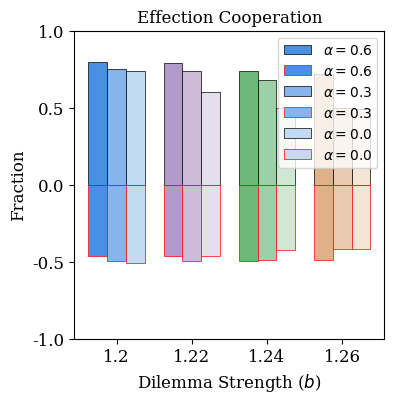

In [14]:
Nr=1
Nc=1

fig, axs = plt.subplots(Nr, Nc, figsize=(4, 4))
plt.subplots_adjust(wspace=0.3, hspace=0.2)


bar_width = 0.25
multiplier = 0
for m_idx,memory_length in enumerate(plot_memory[::-1]):
  offset=bar_width*m_idx
  main_color = main_colors[m_idx % len(main_colors)]
  axs.bar(x+offset, effection_cooperation_memory_length[memory_length], bar_width, label= f'$\\alpha={memory_alpha[::-1][m_idx]}$',color=main_color,edgecolor='black',linewidth=0.5)
  axs.bar(x+offset, effection_defection_memory_length[memory_length], bar_width, label= f'$\\alpha={memory_alpha[::-1][m_idx]}$',color=main_color,edgecolor='red',linewidth=0.5)

y_1=-1
y_2=1
axs.set_ylim(y_1, y_2)
axs.set_title('Effection Cooperation',fontsize=two_figure_font_size)

axs.set_yticks(np.linspace(y_1, y_2, 5))
axs.set_yticklabels(np.around(np.linspace(y_1, y_2, 5), decimals=1),fontsize=two_figure_font_size)
# axs.legend(loc='upper right', ncols=1,fontsize=two_figure_font_size-2)

axs.set_xlabel('Dilemma Strength ('+r'$b$'+')',fontsize=two_figure_font_size)
axs.set_ylabel('Fraction',fontsize=two_figure_font_size)
axs.set_xticks(x + bar_width, plot_dilemma,fontsize=two_figure_font_size)
axs.legend(loc='upper right', ncols=1,fontsize=two_figure_font_size-2)

# plt.savefig('/content/drive/MyDrive/inteaction_dynamics_in_social_dilemmas/figures/S1_effective_connection.eps', format='eps')
plt.show()

### Strategy Network Only

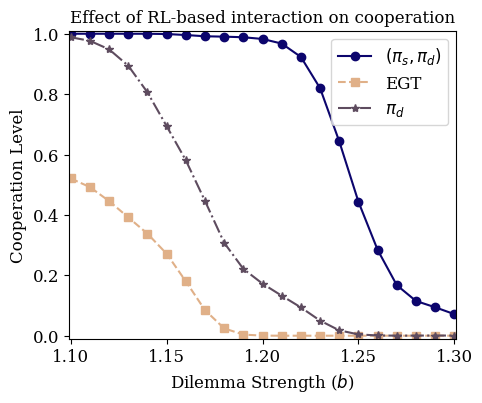

In [15]:

# Assuming final_column_means_all_files and suffixes are already computed

plt.figure(figsize=(5,4))

xaxis_label=[]

legend_list=['EGT','$(\\pi_s,\\pi_d)$','$\\pi_d$']

# Find the maximum length of lists in the dictionary
max_length = max(len(lst) for lst in file_suffixes.values())

# Pad shorter lists with np.nan
padded_lists = [lst + [np.nan] * (max_length - len(lst)) for lst in file_suffixes.values()]

# Convert to a NumPy array
numpy_array = np.array(padded_lists)

for prefix in final_column_means_all_files.keys():
    if "M4" in  prefix and 'one' not in prefix:
      # Get the means and corresponding suffixes for the current prefix
      means_list = final_column_means_all_files[prefix]
      suffix_list = file_suffixes[prefix]
      xaxis_label.append(suffix_list)

      # Flatten the list of means and calculate the overall mean for each file
      means = [np.mean(means) for means in means_list]

      sorted_pairs = sorted(zip(suffix_list, means))
      means = [item for _, item in sorted_pairs]
      suffix_list = [item for item, _ in sorted_pairs]

      # Calculate standard error (SE = standard deviation / sqrt(number of observations))
      standard_errors = [np.std(means) / np.sqrt(len(means)) for _ in means]

      if 'egt' in prefix:
        legend_label=legend_list[0]
        linestyle = '--'
        marker = 's'
        color =  '#e0b088'
      elif 'strar' in prefix:
         legend_label=legend_list[2]
         linestyle = '-.'
         marker = '*'
         color = '#5e4c5f'
      elif 'rl' in prefix:
         legend_label=legend_list[1]
         linestyle = '-'
         marker = 'o'
         color = strategy_color_set[0]




      RL_dillemma_mean=means

      # Plotting each line with error band
      plt.plot(suffix_list,gaussian_filter(means,sigma=1), color=color,label=legend_label, marker=marker,linestyle=linestyle)
      # plt.fill_between(suffix_list, np.array(means) - np.array(standard_errors), np.array(means) + np.array(standard_errors), alpha=0.2)




# Set y-axis limits and x-axis limits
plt.ylim(-0.01, 1.01)
plt.xlim(1.099, 1.301)


# Labeling the plot
plt.xlabel('Dilemma Strength ('+r'$b$'+')', fontsize=single_figure_font_size)
plt.ylabel('Cooperation Level',fontsize=single_figure_font_size)
plt.title('Effect of RL-based interaction on cooperation',fontsize=single_figure_font_size)
plt.legend(fontsize=single_figure_font_size,loc='best')

x_ticks = np.linspace(np.nanmin(numpy_array), np.nanmax(numpy_array), 5)
plt.xticks(np.around(x_ticks,decimals=2),fontsize=single_figure_font_size)
plt.yticks(fontsize=single_figure_font_size)

# Setting the x-axis to display with 2 decimal places
plt.gca().xaxis.set_major_formatter(plt.FormatStrFormatter('%.2f'))

# Display the plot
plt.show()
# plt.savefig('/content/drive/MyDrive/inteaction_dynamics_in_social_dilemmas/figures/S2_different_models.eps', format='eps')

## Statical Result

### Payoff

In [16]:
data_prefix=['Ep.','CP.','Def.']
columns=["Mean", "Median", "Std", "Var", "Min", "Max"]

row_names=plot_dilemma
decimal_round=2

def calculate_statistics(data_arrays):
  '''
  Function to calculate statistics and return DataFrame
  '''
  stats_list = []
  for array in data_arrays:
      stats = {
            columns[0]: round(np.mean(array), decimal_round),
            columns[1]: round(np.median(array), decimal_round),
            columns[2]: round(np.std(array), decimal_round),
            columns[3]: round(np.var(array), decimal_round),
            columns[4]: round(np.min(array), decimal_round),
            columns[5]: round(np.max(array), decimal_round)
        }
      stats_list.append(stats)
  return pd.DataFrame(stats_list)

stats_df=[]
for idx,payoff_data in enumerate(plot_payoff_data):
  stats_df.append(calculate_statistics(payoff_data))

combined_df = []
for i, column in enumerate(columns):
    # Concatenating the same column from each DataFrame
    df_columns = pd.concat([df[column] for df in stats_df], axis=1)

    # Adding a prefix to each column in the concatenated DataFrame
    # The prefix is based on the index of the DataFrame in the list
    df_columns.columns = [f'{data_prefix[i]}{col}' for i, col in enumerate(df_columns.columns)]

    combined_df.append(df_columns)


combined_stats_df = pd.concat(combined_df, axis=1)

# Concatenating the DataFrames side by side
combined_stats_df.index = row_names

combined_stats_df

,Ep.Mean,CP.Mean,Def.Mean,Ep.Median,CP.Median,Def.Median,Ep.Std,CP.Std,Def.Std,Ep.Var,CP.Var,Def.Var,Ep.Min,CP.Min,Def.Min,Ep.Max,CP.Max,Def.Max
1.20,2.67,3.52,1.41,2.52,3.59,1.33,0.41,0.16,0.38,0.17,0.02,0.14,2.15,3.18,0.96,3.48,3.64,2.40
1.22,2.25,3.41,1.10,2.21,3.40,1.01,0.15,0.08,0.22,0.02,0.01,0.05,2.08,3.32,0.83,2.49,3.52,1.47
1.24,1.74,2.86,0.62,1.76,2.90,0.61,0.13,0.16,0.12,0.02,0.02,0.01,1.55,2.63,0.44,1.94,3.05,0.88
1.26,1.33,2.34,0.31,1.39,2.43,0.35,0.15,0.21,0.10,0.02,0.04,0.01,1.09,2.02,0.16,1.48,2.59,0.44


### Link and Interaction

In [17]:
columns_name=['M1','M2','M4']
prefix_name=["Eff.C", "Eff.D",'Dens.cc','Dens.cd','Dens.dd','Int.cc','Int.cd','Int.dd','Con.C','Con.D']

df_column=[]
for prefix in prefix_name:
  for column in columns_name:
    df_column.append(f'{prefix}_{column}')


row_names=plot_dilemma

def generate_column(data_arrays):
  '''
  Function to calculate statistics and return DataFrame
  '''
  df_array=[]
  for data in data_arrays:
    df=pd.DataFrame(data)
    df_array.append(df)


  return pd.concat(df_array, axis=1)

df_interaction=generate_column(interaction_column_data)

df_interaction.columns = df_column


# Concatenating the DataFrames side by side
df_interaction.index = row_names

pd.set_option('display.max_columns', 500)
df_interaction

,Eff.C_M1,Eff.C_M2,Eff.C_M4,Eff.D_M1,Eff.D_M2,Eff.D_M4,Dens.cc_M1,Dens.cc_M2,Dens.cc_M4,Dens.cd_M1,Dens.cd_M2,Dens.cd_M4,Dens.dd_M1,Dens.dd_M2,Dens.dd_M4,Int.cc_M1,Int.cc_M2,Int.cc_M4,Int.cd_M1,Int.cd_M2,Int.cd_M4,Int.dd_M1,Int.dd_M2,Int.dd_M4,Con.C_M1,Con.C_M2,Con.C_M4,Con.D_M1,Con.D_M2,Con.D_M4
1.20,0.74,0.75,0.80,0.51,0.50,0.46,0.52,0.87,0.98,0.08,0.05,0.01,0.40,0.08,0.01,0.83,0.76,0.79,0.61,0.61,0.63,0.49,0.47,0.43,0.86,0.88,0.90,0.77,0.75,0.55
1.22,0.60,0.74,0.79,0.46,0.50,0.46,0.13,0.61,0.97,0.07,0.07,0.02,0.80,0.32,0.02,0.76,0.81,0.78,0.55,0.61,0.61,0.48,0.47,0.45,0.78,0.87,0.91,0.70,0.77,0.64
1.24,0.50,0.68,0.74,0.42,0.49,0.50,0.01,0.27,0.63,0.06,0.11,0.10,0.92,0.61,0.27,0.51,0.79,0.81,0.49,0.57,0.62,0.47,0.48,0.47,0.74,0.83,0.86,0.61,0.79,0.77
1.26,0.49,0.50,0.72,0.41,0.42,0.49,0.02,0.01,0.57,0.08,0.06,0.09,0.90,0.93,0.34,0.59,0.56,0.78,0.51,0.49,0.60,0.47,0.46,0.46,0.61,0.75,0.85,0.53,0.61,0.80


### Dual or Singe Network

In [22]:
columns_name=['Coop',"Eff.C",'Payoff.EP','Payoff.C','Gini']


row_names=['dual','single']

# print(dual_singe_column_data)

df_dual_single=generate_column(dual_singe_column_data)

# df_interaction.columns = df_column
df_dual_single.columns = columns_name
df_dual_single.index = row_names

df_dual_single

,Coop,Eff.C,Payoff.EP,Payoff.C,Gini
dual,0.987,0.80,2.67,3.52,0.11
single,1.000,0.67,2.85,2.85,0.17
